In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
import time

# --- Global Configuration ---
N = 8  # Number of grid points (Discretization) - MUST be a power of 2
n_qubits = int(np.log2(N))
nu = 0.01  # Viscosity parameter
h = 1.0 / (N + 1)
dt = 1e-3
x_grid = np.linspace(1, N, N) * h

In [2]:
def build_A(N, nu, dt, h):
    """Builds the implicit matrix for the diffusion step."""
    alpha = nu * dt / (h**2)
    diag = np.ones(N) * (1 + 2*alpha)
    off = np.ones(N-1) * (-alpha)
    A = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)
    return A

def advect_upwind(u, dt, h):
    """Handles the non-linear advection step using an upwind scheme."""
    N = len(u)
    ustar = u.copy()
    for i in range(1, N-1):
        dudx = (u[i] - u[i-1]) / h
        ustar[i] = u[i] - dt * u[i] * dudx
    # Enforce Boundary Conditions
    ustar[0] = 0.0
    ustar[-1] = 0.0
    return ustar

# --- Classical Solver Execution ---

def run_classical_solver(u_initial, max_steps=500):
    """
    Runs the full classical simulation and returns the history of the solution.
    """
    print("--- Running Classical Solver ---")
    u_history = [u_initial.copy()]
    u_n = u_initial.copy()
    A = build_A(N, nu, dt, h)
    start_time = time.time()

    for step in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_new = np.linalg.solve(A, u_star)
        u_n = u_new
        u_history.append(u_n)

    end_time = time.time()
    print(f"Classical solver finished in {end_time - start_time:.2f} seconds.")
    return np.array(u_history)

In [8]:
class QPINN:
    """
    A Quantum Physics-Informed Neural Network for solving PDEs.
    """
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.reps = n_qubits # Reps scale with problem size
        self.n_params = (self.reps + 1) * self.n_qubits
        self.optimal_params = None

    def get_solution_ansatz(self, params, t):
        """
        The quantum circuit that approximates the solution u_θ(x, t).
        Time 't' is encoded into the rotation angles.
        """
        time_dependent_params = [p * np.cos(t * i) for i, p in enumerate(params)]
        ansatz = TwoLocal(self.n_qubits, 'ry', 'cz', entanglement='circular', reps=self.reps)
        bound_qc = ansatz.assign_parameters(time_dependent_params)
        sv = Statevector(bound_qc).data
        return np.real(sv)

    # IN THE QPINN CLASS...
    def loss_function(self, params, u_initial):
        """
        The physics-informed loss function.
        """
        u_0 = self.get_solution_ansatz(params, 0)
        u_1 = self.get_solution_ansatz(params, dt)

        # We need to normalize the initial state from the ansatz before comparing
        u_0_normalized = u_0 * np.linalg.norm(u_initial) / np.linalg.norm(u_0)

        # INCREASE THE WEIGHT HERE
        loss_ic = np.mean((u_0_normalized - u_initial)**2)

        u_t = (u_1 - u_0) / dt
        u_x = np.gradient(u_0, h)
        u_xx = np.gradient(u_x, h)

        pde_residual = u_t + u_0 * u_x - nu * u_xx
        loss_pde = np.mean(pde_residual**2)

        # A much stronger weight for the initial condition
        return 500 * loss_ic + loss_pde

    def train(self, u_initial, max_iter=200):
        """
        Train the QPINN by minimizing the loss function.
        """
        print("\n--- Training QPINN ---")
        initial_params = np.random.rand(self.n_params) * np.pi
        objective_function = lambda p: self.loss_function(p, u_initial)
        
        start_time = time.time()
        res = minimize(objective_function, initial_params, method='L-BFGS-B',
                       options={'maxiter': max_iter, 'disp': True})
        end_time = time.time()
        print(f"QPINN training finished in {end_time - start_time:.2f} seconds.")
        self.optimal_params = res.x

    # IN THE QPINN CLASS...
    def predict_evolution(self, u_initial, num_steps):
        """
        Predicts the full time evolution after the model has been trained.
        """
        if self.optimal_params is None:
            self.train(u_initial)

        print("\n--- Predicting with Trained QPINN ---")
        u_history = []
        norm_initial = np.linalg.norm(u_initial) # Get the target "energy"

        for step in range(num_steps + 1):
            t = step * dt
            u_t = self.get_solution_ansatz(self.optimal_params, t)

            # CRITICAL FIX: Re-normalize the solution at each step
            current_norm = np.linalg.norm(u_t)
            if current_norm > 1e-9: # Avoid division by zero
                u_t_normalized = u_t * (norm_initial / current_norm)
            else:
                u_t_normalized = u_t # It's already zero

            u_history.append(u_t_normalized)
            
        return np.array(u_history)

--- Running Classical Solver ---
Classical solver finished in 0.00 seconds.

--- Training QPINN ---


C:\Users\navan\AppData\Local\Temp\ipykernel_45296\3924295119.py:55: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(objective_function, initial_params, method='L-BFGS-B',
C:\Users\navan\AppData\Local\Temp\ipykernel_45296\3924295119.py:17: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(self.n_qubits, 'ry', 'cz', entanglement='circular', reps=self.reps)


QPINN training finished in 30.60 seconds.

--- Predicting with Trained QPINN ---

Saving animation...
Animation saved as classical_vs_qpin_solution.gif


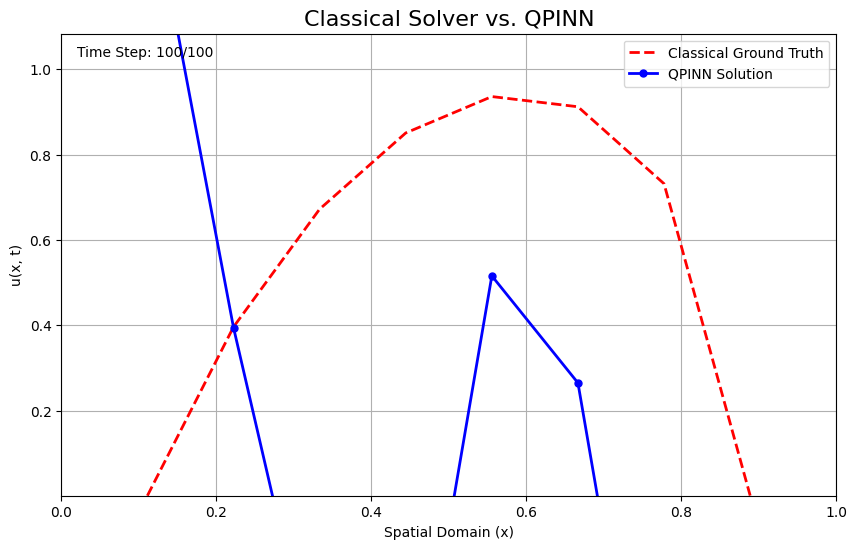

In [9]:
# --- Define Initial Condition ---
def sine_wave(x):
    return np.sin(np.pi * x)

u_initial = sine_wave(x_grid)
num_steps = 100 # Number of time steps for the simulation

# --- Run Solvers ---
classical_history = run_classical_solver(u_initial, max_steps=num_steps)

qpin = QPINN(n_qubits)
qpin_history = qpin.predict_evolution(u_initial, num_steps=num_steps)

# --- Final Visualization and Analysis ---

def create_comparison_animation(classical_hist, qpin_hist, num_frames):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlim(0, 1)
    ax.set_ylim(np.min(classical_hist), np.max(classical_hist) * 1.1)
    ax.set_title('Classical Solver vs. QPINN', fontsize=16)
    ax.set_xlabel('Spatial Domain (x)')
    ax.set_ylabel('u(x, t)')
    ax.grid(True)

    line_classical, = ax.plot([], [], 'r--', lw=2, label='Classical Ground Truth')
    line_qpin, = ax.plot([], [], 'bo-', lw=2, markersize=5, label='QPINN Solution')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    ax.legend()

    def update(frame):
        line_classical.set_data(x_grid, classical_hist[frame])
        line_qpin.set_data(x_grid, qpin_hist[frame])
        time_text.set_text(f'Time Step: {frame}/{num_frames}')
        return line_classical, line_qpin, time_text

    ani = animation.FuncAnimation(fig, update, frames=num_frames + 1, blit=True, interval=50)
    
    print("\nSaving animation...")
    ani.save('classical_vs_qpin_solution.gif', writer='pillow', fps=20)
    print("Animation saved as classical_vs_qpin_solution.gif")
    plt.show()

create_comparison_animation(classical_history, qpin_history, num_steps)

--- Running Classical Linear Advection Solver ---
Classical solver finished.

--- Training QPINN on Linear Advection ---


C:\Users\navan\AppData\Local\Temp\ipykernel_45296\884736458.py:71: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(objective_function, initial_params, method='L-BFGS-B',
C:\Users\navan\AppData\Local\Temp\ipykernel_45296\884736458.py:45: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  ansatz = TwoLocal(self.n_qubits, 'ry', 'cz', entanglement='circular', reps=self.reps)


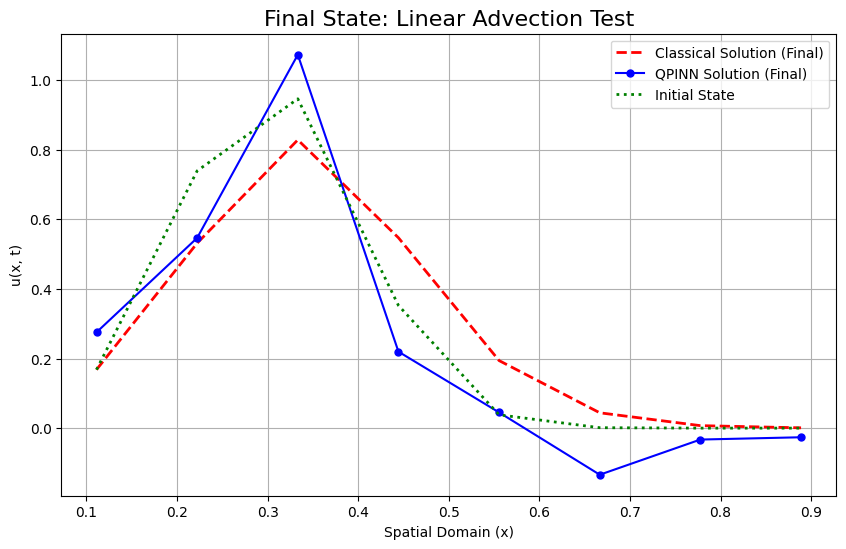

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
import time

# --- Global Configuration ---
N = 8
n_qubits = int(np.log2(N))
h = 1.0 / (N + 1)
dt = 1e-3
x_grid = np.linspace(1, N, N) * h
ADVECTION_SPEED = 1.0 # The 'c' in our new equation

# --- METHODOLOGY 1: CLASSICAL SOLVER (for the new, simpler PDE) ---
def run_classical_advection_solver(u_initial, max_steps=100):
    print("--- Running Classical Linear Advection Solver ---")
    u_history = [u_initial.copy()]
    u_n = u_initial.copy()
    
    # Using a simple upwind scheme for u_t + c * u_x = 0
    # u_new[i] = u_old[i] - c * dt/h * (u_old[i] - u_old[i-1])
    for _ in range(max_steps):
        u_old = u_n.copy()
        for i in range(1, N):
            u_n[i] = u_old[i] - ADVECTION_SPEED * (dt/h) * (u_old[i] - u_old[i-1])
        u_history.append(u_n.copy())
        
    print("Classical solver finished.")
    return np.array(u_history)

# --- METHODOLOGY 2: QPINN (for the new, simpler PDE) ---
class QPINN:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.reps = n_qubits
        self.n_params = (self.reps + 1) * self.n_qubits
        self.optimal_params = None

    def get_solution_ansatz(self, params, t):
        time_dependent_params = [p * np.cos(t * i * ADVECTION_SPEED) for i, p in enumerate(params)]
        ansatz = TwoLocal(self.n_qubits, 'ry', 'cz', entanglement='circular', reps=self.reps)
        bound_qc = ansatz.assign_parameters(time_dependent_params)
        sv = Statevector(bound_qc).data
        return np.real(sv)

    def loss_function(self, params, u_initial, loss_weight):
        u_0 = self.get_solution_ansatz(params, 0)
        u_1 = self.get_solution_ansatz(params, dt)
        
        norm_u0 = np.linalg.norm(u_0)
        u_0_normalized = u_0 * (np.linalg.norm(u_initial) / norm_u0) if norm_u0 > 1e-9 else u_0
        loss_ic = np.mean((u_0_normalized - u_initial)**2)
        
        # **SIMPLIFIED PHYSICS**: Linear Advection Residual
        u_t = (u_1 - u_0) / dt
        u_x = np.gradient(u_0, h)
        pde_residual = u_t + ADVECTION_SPEED * u_x
        loss_pde = np.mean(pde_residual**2)
        
        return loss_weight * loss_ic + loss_pde

    def train(self, u_initial, max_iter=300, loss_weight=1000):
        print("\n--- Training QPINN on Linear Advection ---")
        initial_params = np.random.rand(self.n_params) * np.pi
        objective_function = lambda p: self.loss_function(p, u_initial, loss_weight)
        
        res = minimize(objective_function, initial_params, method='L-BFGS-B',
                       options={'maxiter': max_iter, 'disp': True})
        self.optimal_params = res.x

    def predict_evolution(self, u_initial, num_steps):
        if self.optimal_params is None:
            self.train(u_initial)
        
        u_history = []
        norm_initial = np.linalg.norm(u_initial)
        for step in range(num_steps + 1):
            t = step * dt
            u_t = self.get_solution_ansatz(self.optimal_params, t)
            current_norm = np.linalg.norm(u_t)
            u_t_normalized = u_t * (norm_initial / current_norm) if current_norm > 1e-9 else u_t
            u_history.append(u_t_normalized)
        return np.array(u_history)

# --- EXECUTION AND VISUALIZATION ---
def main():
    # A Gaussian wave is better for this test than a sine wave
    def gaussian(x, mu=0.3, sigma=0.1):
        return np.exp(-0.5 * ((x - mu) / sigma)**2)

    u_initial = gaussian(x_grid)
    num_steps = 50

    classical_history = run_classical_advection_solver(u_initial, max_steps=num_steps)
    qpin = QPINN(n_qubits)
    qpin_history = qpin.predict_evolution(u_initial, num_steps=num_steps)

    plt.figure(figsize=(10, 6))
    plt.plot(x_grid, classical_history[-1], 'r--', lw=2, label=f'Classical Solution (Final)')
    plt.plot(x_grid, qpin_history[-1], 'bo-', markersize=5, label=f'QPINN Solution (Final)')
    plt.plot(x_grid, u_initial, 'g:', lw=2, label='Initial State')
    plt.title('Final State: Linear Advection Test', fontsize=16)
    plt.xlabel('Spatial Domain (x)')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the simplified experiment
main()

--- Generating 40 diverse training samples... ---

--- Starting model training... ---


C:\Users\navan\AppData\Local\Temp\ipykernel_45296\2262551698.py:104: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(objective_function, model.params, method='L-BFGS-B', options={'maxiter': max_iter, 'disp': True})



--- Testing trained model on a new, unseen PDE... ---

Prediction complete. Mean Squared Error (MSE): 1.98e-02


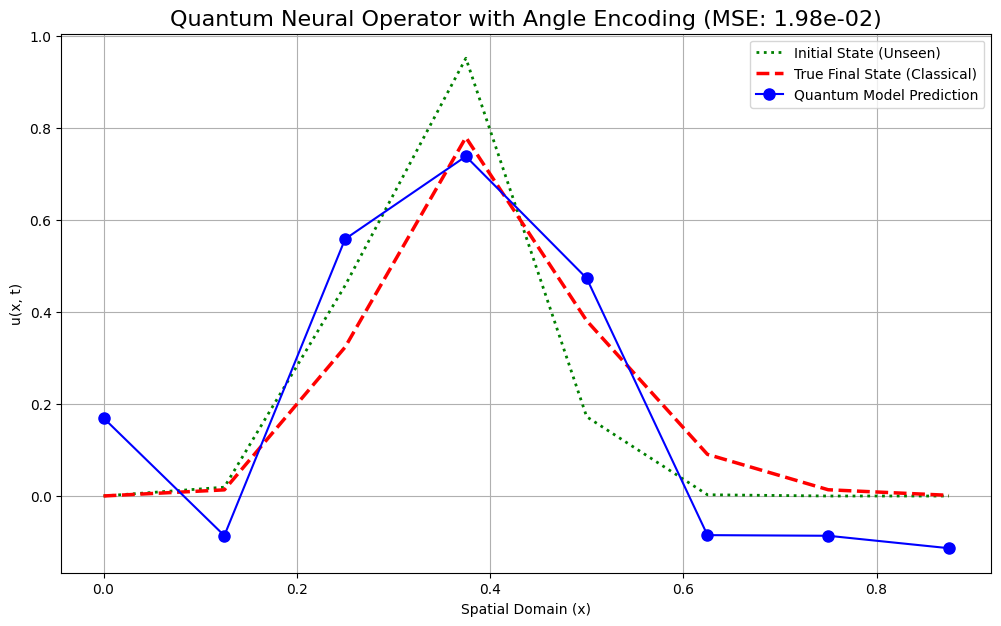

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, AncillaRegister
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import time

# --- STEP 1: DATA GENERATION (No changes here) ---
def run_classical_advection_solver(u_initial, advection_speed, num_steps, dt, h):
    u_history = [u_initial.copy()]
    u_n = u_initial.copy()
    N = len(u_initial)
    for _ in range(num_steps):
        u_old = u_n.copy()
        for i in range(1, N):
            u_n[i] = u_old[i] - advection_speed * (dt/h) * (u_old[i] - u_old[i-1])
        u_history.append(u_n.copy())
    return u_history[-1]

def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma)**2)

def generate_dataset(num_samples, N, num_steps, dt, h):
    print(f"--- Generating {num_samples} diverse training samples... ---")
    x_grid = np.linspace(0, 1, N, endpoint=False)
    dataset = []
    for i in range(num_samples):
        mu = 0.2 + 0.6 * np.random.rand()
        sigma = 0.05 + 0.05 * np.random.rand()
        advection_speed = 0.8 + 0.4 * np.random.rand()
        
        u_initial = gaussian(x_grid, mu=mu, sigma=sigma)
        u_final = run_classical_advection_solver(u_initial, advection_speed, num_steps, dt, h)
        dataset.append({'initial': u_initial, 'final': u_final, 'speed': advection_speed})
    return dataset

# --- STEP 2: UPGRADED QUANTUM MODEL WITH ANGLE ENCODING ---
class QuantumNeuralOperator:
    def __init__(self, n_qubits, reps):
        self.n_qubits = n_qubits
        self.reps = reps
        
        # Create a circuit with distinct placeholders for data and weights
        num_inputs = self.n_qubits
        self.input_params = ParameterVector('x', num_inputs)
        self.weight_params = ParameterVector('w', reps * n_qubits * 2) # For RY and RZ gates
        
        # Build the circuit structure
        self.circuit = self._build_circuit()
        self.params = np.random.uniform(-np.pi, np.pi, size=len(self.weight_params))

    def _build_circuit(self):
        """Builds the circuit with separate data and weight parameters."""
        qc = QuantumCircuit(self.n_qubits)
        weight_idx = 0
        for r in range(self.reps):
            for i in range(self.n_qubits):
                # Data encoding layer using RY gates
                qc.ry(self.input_params[i], i)
                # Trainable processing layers using RY and RZ gates
                qc.rz(self.weight_params[weight_idx], i)
                qc.ry(self.weight_params[weight_idx + 1], i)
                weight_idx += 2
            # Entangling layer
            for i in range(self.n_qubits - 1):
                qc.cx(i, i+1)
        return qc

    def forward(self, initial_condition, advection_speed):
        # Bind the initial condition and speed to the input parameters
        # We combine them to ensure all info gets in
        input_data = [u * advection_speed for u in initial_condition]
        
        # Bind the trainable weights
        param_dict = {p: v for p, v in zip(self.input_params, input_data)}
        param_dict.update({p: v for p, v in zip(self.weight_params, self.params)})
        
        bound_circuit = self.circuit.assign_parameters(param_dict)
        
        sv = Statevector(bound_circuit).data
        prediction = np.real(sv)
        
        norm_initial = np.linalg.norm(initial_condition)
        norm_prediction = np.linalg.norm(prediction)
        if norm_prediction > 1e-9:
            prediction = prediction * (norm_initial / norm_prediction)
        return prediction

    def loss(self, params, training_data):
        self.params = params
        total_loss = 0.0
        for sample in training_data:
            u_final_pred = self.forward(sample['initial'], sample['speed'])
            total_loss += np.mean((u_final_pred - sample['final'])**2)
        return total_loss / len(training_data)

# --- STEPS 3 & 4: TRAINING AND INFERENCE (Updated main function) ---
def train_model(model, dataset, max_iter):
    print("\n--- Starting model training... ---")
    objective_function = lambda p: model.loss(p, dataset)
    res = minimize(objective_function, model.params, method='L-BFGS-B', options={'maxiter': max_iter, 'disp': True})
    model.params = res.x
    return model

def main():
    N = 8 # Start with a smaller problem (8 points = 3 qubits) to make it easier to learn
    n_qubits = int(np.log2(N))
    num_training_samples = 40
    max_training_iter = 80
    circuit_reps = 3 # A reasonable depth
    
    num_steps = 50
    dt = 1e-3
    h = 1.0 / N

    training_dataset = generate_dataset(num_training_samples, N, num_steps, dt, h)
    qno_model = QuantumNeuralOperator(n_qubits, reps=circuit_reps)
    qno_model = train_model(qno_model, training_dataset, max_iter=max_training_iter)
    
    print("\n--- Testing trained model on a new, unseen PDE... ---")
    x_grid = np.linspace(0, 1, N, endpoint=False)
    test_mu, test_sigma, test_speed = 0.35, 0.08, 0.9
    
    u_initial_test = gaussian(x_grid, mu=test_mu, sigma=test_sigma)
    u_final_true = run_classical_advection_solver(u_initial_test, test_speed, num_steps, dt, h)
    u_final_pred = qno_model.forward(u_initial_test, test_speed)
    
    mse = mean_squared_error(u_final_true, u_final_pred)
    print(f"\nPrediction complete. Mean Squared Error (MSE): {mse:.2e}")
    
    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial_test, 'g:', lw=2, label='Initial State (Unseen)')
    plt.plot(x_grid, u_final_true, 'r--', lw=2.5, label='True Final State (Classical)')
    plt.plot(x_grid, u_final_pred, 'bo-', markersize=8, label='Quantum Model Prediction')
    plt.title(f'Quantum Neural Operator with Angle Encoding (MSE: {mse:.2e})', fontsize=16)
    plt.xlabel('Spatial Domain (x)')
    plt.ylabel('u(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

main()

In [27]:
# model.py
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.quantum_info import Statevector
import os

# --- CLASSICAL SOLVER FUNCTIONS (Used by both scripts) ---

def run_classical_burgers_solver(u_initial, max_steps, N, nu, dt, h):
    u_history = [u_initial.copy()]
    u_n = u_initial.copy()
    A = build_A(N, nu, dt, h)
    for _ in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_n = np.linalg.solve(A, u_star)
        u_history.append(u_n)
    return u_history[-1]

def build_A(N, nu, dt, h):
    alpha = nu * dt / (h**2)
    diag = np.ones(N) * (1 + 2*alpha)
    off = np.ones(N-1) * (-alpha)
    return np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)

def advect_upwind(u, dt, h):
    N = len(u)
    ustar = u.copy()
    for i in range(1, N-1):
        dudx = (u[i] - u[i-1]) / h
        ustar[i] = u[i] - dt * u[i] * dudx
    ustar[0], ustar[-1] = 0.0, 0.0
    return ustar

# --- QUANTUM MODEL DEFINITION ---

class QuantumNeuralOperator:
    def __init__(self, n_qubits, reps):
        self.n_qubits = n_qubits
        self.reps = reps
        self.input_params = ParameterVector('x', self.n_qubits)
        self.weight_params = ParameterVector('w', reps * n_qubits * 2)
        self.circuit = self._build_circuit()
        self.params = np.random.uniform(-np.pi, np.pi, size=len(self.weight_params))

    def _build_circuit(self):
        qc = QuantumCircuit(self.n_qubits)
        weight_idx = 0
        for r in range(self.reps):
            for i in range(self.n_qubits):
                qc.ry(self.input_params[i], i)
                qc.rz(self.weight_params[weight_idx], i)
                qc.ry(self.weight_params[weight_idx + 1], i)
                weight_idx += 2
            for i in range(self.n_qubits - 1): qc.cx(i, i+1)
        return qc

    def forward(self, initial_condition, nu):
        input_data = [u * nu * 100 for u in initial_condition]
        param_dict = {p: v for p, v in zip(self.input_params, input_data)}
        param_dict.update({p: v for p, v in zip(self.weight_params, self.params)})
        bound_circuit = self.circuit.assign_parameters(param_dict)
        sv = Statevector(bound_circuit).data
        prediction = np.real(sv)
        norm_initial = np.linalg.norm(initial_condition)
        norm_prediction = np.linalg.norm(prediction)
        if norm_prediction > 1e-9:
            prediction = prediction * (norm_initial / norm_prediction)
        return prediction

    def loss(self, params, training_data):
        self.params = params
        total_loss = 0.0
        for sample in training_data:
            u_final_pred = self.forward(sample['initial'], sample['nu'])
            total_loss += np.mean((u_final_pred - sample['final'])**2)
        return total_loss / len(training_data)

    def save_params(self, filepath='burgers_qno_model.npy'):
        np.save(filepath, self.params)
        print(f"--- Model parameters saved to '{filepath}' ---")

    def load_params(self, filepath='burgers_qno_model.npy'):
        if os.path.exists(filepath):
            self.params = np.load(filepath)
            print(f"--- Model parameters loaded from '{filepath}' ---")
        else:
            raise FileNotFoundError(f"Model file not found at '{filepath}'. Please train the model first.")

In [29]:
# train.py
import numpy as np
from scipy.optimize import minimize
import time

# Import the shared model and data generation functions
def train_new_model(hyperparams):
    """Trains a new QNO model with specified hyperparameters and saves it."""
    print("\n" + "="*50)
    print("            STARTING NEW TRAINING RUN")
    print("="*50)
    
    # Unpack hyperparameters
    N, num_training_samples, max_training_iter, circuit_reps = hyperparams.values()
    n_qubits = int(np.log2(N))
    
    # Standard simulation settings
    num_steps, dt, h = 100, 1e-3, 1.0 / N

    training_dataset = generate_burgers_dataset(num_training_samples, N, num_steps, dt, h)
    qno_model = QuantumNeuralOperator(n_qubits, reps=circuit_reps)
    
    print("\n--- Training Quantum Surrogate Model on Burgers' Equation... ---")
    objective_function = lambda p: qno_model.loss(p, training_dataset)
    res = minimize(objective_function, qno_model.params, method='L-BFGS-B', 
                   options={'maxiter': max_training_iter, 'disp': True})
    qno_model.params = res.x
    
    qno_model.save_params()
    return qno_model

# --- MAIN EXECUTION FOR TRAINING ---
if __name__ == '__main__':
    # Define the hyperparameters for our training run
    HYPERPARAMS = {
        'N': 8,
        'num_training_samples': 100,
        'max_training_iter': 200,
        'circuit_reps': 6
    }
    
    # This will train the model and save the file 'burgers_qno_model.npy'
    train_new_model(HYPERPARAMS)


            STARTING NEW TRAINING RUN
--- Generating 100 training samples for Burgers' Equation... ---
Generated sample 1/100 with nu = 0.0150
Generated sample 2/100 with nu = 0.0168
Generated sample 3/100 with nu = 0.0269
Generated sample 4/100 with nu = 0.0410
Generated sample 5/100 with nu = 0.0333
Generated sample 6/100 with nu = 0.0252
Generated sample 7/100 with nu = 0.0100
Generated sample 8/100 with nu = 0.0400
Generated sample 9/100 with nu = 0.0321
Generated sample 10/100 with nu = 0.0428
Generated sample 11/100 with nu = 0.0292
Generated sample 12/100 with nu = 0.0113
Generated sample 13/100 with nu = 0.0362
Generated sample 14/100 with nu = 0.0471
Generated sample 15/100 with nu = 0.0305
Generated sample 16/100 with nu = 0.0119
Generated sample 17/100 with nu = 0.0125
Generated sample 18/100 with nu = 0.0117
Generated sample 19/100 with nu = 0.0214
Generated sample 20/100 with nu = 0.0129
Generated sample 21/100 with nu = 0.0308
Generated sample 22/100 with nu = 0.0284
Gen

C:\Users\navan\AppData\Local\Temp\ipykernel_45296\2795182961.py:25: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(objective_function, qno_model.params, method='L-BFGS-B',


--- Model parameters saved to 'burgers_qno_model.npy' ---



      PREDICTING FOR UNSEEN NU = 0.0180
--- Model parameters loaded from 'burgers_qno_model.npy' ---
Quantum prediction took 0.004011 seconds.
Prediction complete. MSE: 9.35e-03


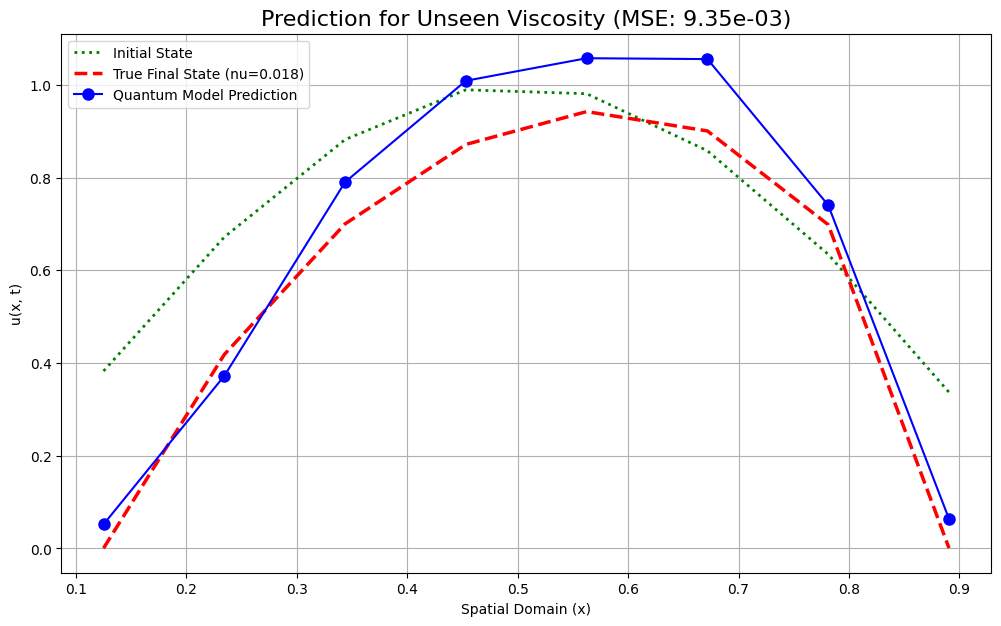


      PREDICTING FOR UNSEEN NU = 0.0330
--- Model parameters loaded from 'burgers_qno_model.npy' ---
Quantum prediction took 0.004066 seconds.
Prediction complete. MSE: 1.14e-02


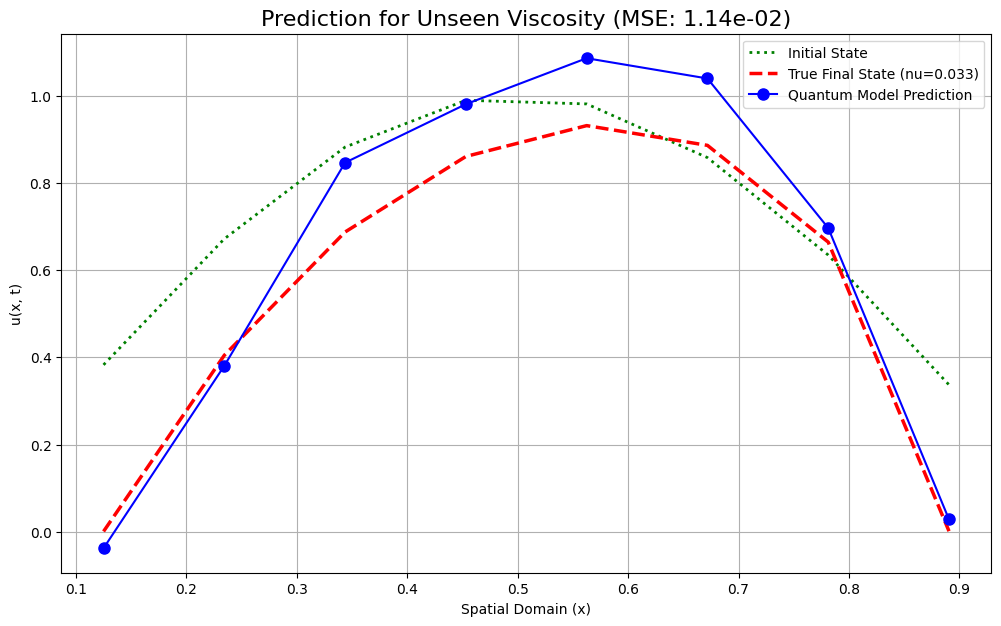


      PREDICTING FOR UNSEEN NU = 0.0470
--- Model parameters loaded from 'burgers_qno_model.npy' ---
Quantum prediction took 0.003856 seconds.
Prediction complete. MSE: 1.60e-02


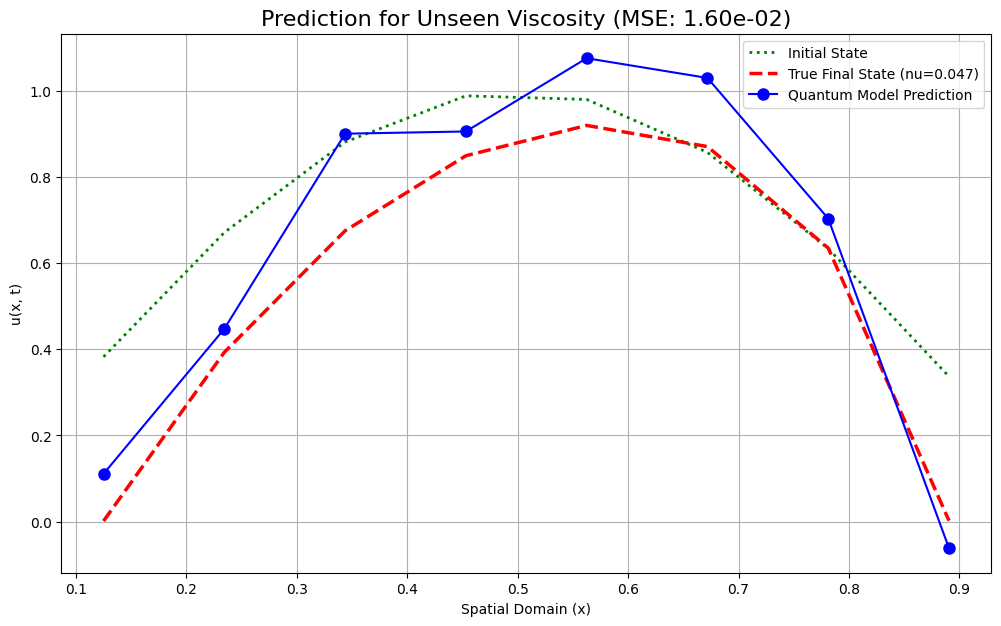

In [30]:
# predict.py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

def predict_new_scenario(unseen_nu, model_config):
    """Loads a pre-trained model and predicts the outcome for a new scenario."""
    print("\n" + "="*50)
    print(f"      PREDICTING FOR UNSEEN NU = {unseen_nu:.4f}")
    print("="*50)

    # Unpack model configuration
    N, circuit_reps = model_config['N'], model_config['circuit_reps']
    n_qubits = int(np.log2(N))
    
    # Load model architecture and its saved parameters
    qno_model = QuantumNeuralOperator(n_qubits, reps=circuit_reps)
    qno_model.load_params()
    
    # Set up the new problem
    num_steps, dt, h = 100, 1e-3, 1.0 / N
    x_grid = np.linspace(h, 1.0, N, endpoint=False)
    u_initial = np.sin(np.pi * x_grid)

    # Get the instant prediction
    start_time = time.time()
    u_final_pred = qno_model.forward(u_initial, unseen_nu)
    end_time = time.time()
    print(f"Quantum prediction took {end_time - start_time:.6f} seconds.")
    
    # Get the true answer for comparison
    u_final_true = run_classical_burgers_solver(u_initial, num_steps, N, unseen_nu, dt, h)
    
    # Analyze and Plot
    mse = mean_squared_error(u_final_true, u_final_pred)
    print(f"Prediction complete. MSE: {mse:.2e}")
    
    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial, 'g:', lw=2, label='Initial State')
    plt.plot(x_grid, u_final_true, 'r--', lw=2.5, label=f'True Final State (nu={unseen_nu:.3f})')
    plt.plot(x_grid, u_final_pred, 'bo-', markersize=8, label='Quantum Model Prediction')
    plt.title(f"Prediction for Unseen Viscosity (MSE: {mse:.2e})", fontsize=16)
    plt.xlabel('Spatial Domain (x)'), plt.ylabel('u(x, t)'), plt.legend(), plt.grid(True)
    plt.show()

# --- MAIN EXECUTION FOR PREDICTION ---
if __name__ == '__main__':
    # This config MUST match the one used for training
    MODEL_CONFIG = {
        'N': 8,
        'circuit_reps': 6
    }
    
    # Use your trained model to predict new scenarios instantly
    predict_new_scenario(unseen_nu=0.018, model_config=MODEL_CONFIG)
    predict_new_scenario(unseen_nu=0.033, model_config=MODEL_CONFIG)
    predict_new_scenario(unseen_nu=0.047, model_config=MODEL_CONFIG)

--- Training QPINN v2.0 on Burgers' Equation ---


C:\Users\navan\AppData\Local\Temp\ipykernel_45296\1166939045.py:104: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(objective_fn, qpin_model.params, method='L-BFGS-B', options={'maxiter': max_training_iter, 'disp': True})


--- Training Complete ---
--- Running Classical Burgers' Solver ---


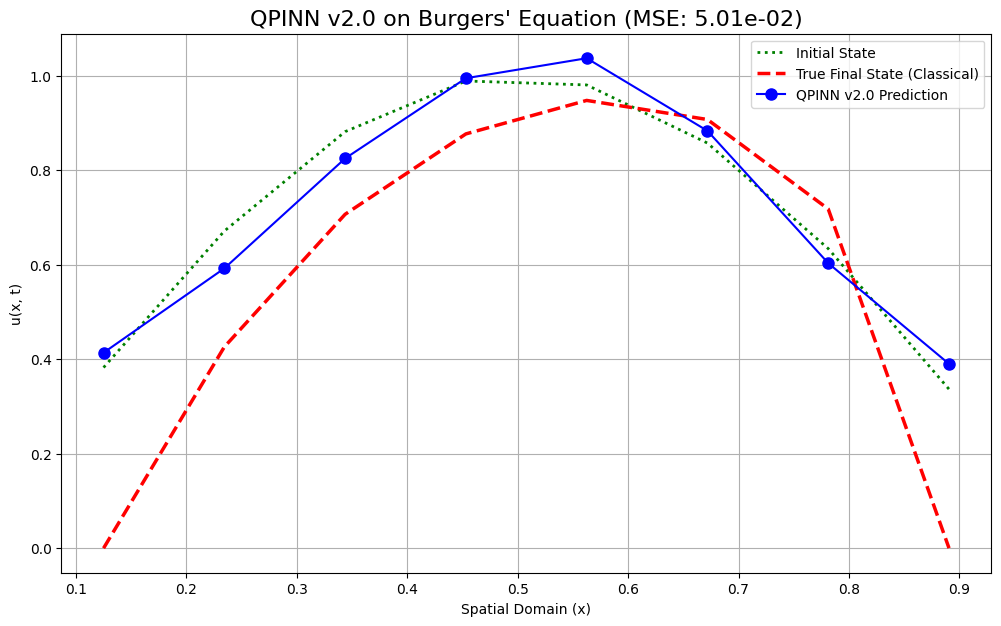

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector # CORRECTED IMPORT
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import time

# --- CLASSICAL BURGERS' SOLVER (Ground Truth) ---
def build_A(N, nu, dt, h):
    alpha = nu * dt / (h**2)
    diag = np.ones(N) * (1 + 2*alpha)
    off = np.ones(N-1) * (-alpha)
    A = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)
    return A

def advect_upwind(u, dt, h):
    N = len(u)
    ustar = u.copy()
    for i in range(1, N-1):
        dudx = (u[i] - u[i-1]) / h
        ustar[i] = u[i] - dt * u[i] * dudx
    ustar[0], ustar[-1] = 0.0, 0.0
    return ustar

def run_classical_burgers_solver(u_initial, max_steps, N, nu, dt, h):
    print("--- Running Classical Burgers' Solver ---")
    u_history = [u_initial.copy()]
    u_n = u_initial.copy()
    A = build_A(N, nu, dt, h)
    for _ in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_n = np.linalg.solve(A, u_star)
        u_history.append(u_n)
    return u_history

# --- QPINN v2.0 with Angle Encoding ---
class QPINN_v2:
    def __init__(self, n_qubits, reps):
        self.n_qubits = n_qubits
        self.reps = reps
        self.time_param = Parameter('t')
        self.weight_params = ParameterVector('w', reps * n_qubits * 2)
        self.circuit = self._build_circuit()
        self.params = np.random.uniform(-np.pi, np.pi, size=len(self.weight_params))

    def _build_circuit(self):
        qc = QuantumCircuit(self.n_qubits)
        weight_idx = 0
        for r in range(self.reps):
            for i in range(self.n_qubits):
                # Time is encoded here, making the circuit a function of t
                qc.ry(self.time_param * (i + 1), i)
                # Trainable processing layers
                qc.rz(self.weight_params[weight_idx], i)
                qc.ry(self.weight_params[weight_idx + 1], i)
                weight_idx += 2
            for i in range(self.n_qubits - 1): qc.cx(i, i+1)
        return qc

    def get_solution_at_t(self, t):
        param_dict = {self.time_param: t}
        param_dict.update({p: v for p, v in zip(self.weight_params, self.params)})
        bound_circuit = self.circuit.assign_parameters(param_dict)
        sv = Statevector(bound_circuit).data
        return np.real(sv)

    def loss_function(self, params, u_initial, N, nu, dt, h):
        self.params = params
        u_0 = self.get_solution_at_t(0)
        u_1 = self.get_solution_at_t(dt)
        
        norm_u0 = np.linalg.norm(u_0)
        u_0_normalized = u_0 * (np.linalg.norm(u_initial) / norm_u0) if norm_u0 > 1e-9 else u_0
        loss_ic = np.mean((u_0_normalized - u_initial)**2)
        
        # **BURGERS' EQUATION RESIDUAL**
        u_t = (u_1 - u_0) / dt
        u_x = np.gradient(u_0, h)
        u_xx = np.gradient(u_x, h)
        pde_residual = u_t + u_0 * u_x - nu * u_xx
        loss_pde = np.mean(pde_residual**2)
        
        return 500 * loss_ic + loss_pde # High weight on the initial condition

# --- MAIN EXECUTION ---
def main():
    N = 8
    n_qubits = int(np.log2(N))
    nu = 0.01
    dt = 1e-3
    h = 1.0 / N
    num_steps = 100
    max_training_iter = 100
    
    x_grid = np.linspace(h, 1.0, N, endpoint=False)
    u_initial = np.sin(np.pi * x_grid)

    # 1. Train the QPINN v2.0 model
    qpin_model = QPINN_v2(n_qubits, reps=3)
    objective_fn = lambda p: qpin_model.loss_function(p, u_initial, N, nu, dt, h)
    print("--- Training QPINN v2.0 on Burgers' Equation ---")
    res = minimize(objective_fn, qpin_model.params, method='L-BFGS-B', options={'maxiter': max_training_iter, 'disp': True})
    qpin_model.params = res.x
    print("--- Training Complete ---")

    # 2. Get predictions and classical solution
    qpin_history = []
    norm_initial = np.linalg.norm(u_initial)
    for t in range(num_steps + 1):
        u_t = qpin_model.get_solution_at_t(t * dt)
        norm_ut = np.linalg.norm(u_t)
        # Re-normalize at each prediction step
        u_t_normalized = u_t * (norm_initial / norm_ut) if norm_ut > 1e-9 else u_t
        qpin_history.append(u_t_normalized)

    classical_history = run_classical_burgers_solver(u_initial, num_steps, N, nu, dt, h)
    
    # 3. Analyze and Plot
    u_final_qpin = qpin_history[-1]
    u_final_classical = classical_history[-1]
    mse = mean_squared_error(u_final_classical, u_final_qpin)
    
    plt.figure(figsize=(12, 7))
    plt.plot(x_grid, u_initial, 'g:', lw=2, label='Initial State')
    plt.plot(x_grid, u_final_classical, 'r--', lw=2.5, label='True Final State (Classical)')
    plt.plot(x_grid, u_final_qpin, 'bo-', markersize=8, label='QPINN v2.0 Prediction')
    plt.title(f"QPINN v2.0 on Burgers' Equation (MSE: {mse:.2e})", fontsize=16)
    plt.xlabel('Spatial Domain (x)'), plt.ylabel('u(x, t)'), plt.legend(), plt.grid(True)
    plt.show()

main()